In [1]:
%matplotlib inline
import numpy as np
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
import os
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
# 500 max word length, LSTM only architecture, 20 of the top level classes, 100 epochs
# predictionPath = 'results/epochPreds_500ML_LSTM_20Class.npy'
# avgLossPath = 'results/epochAvgLoss_500ML_LSTM_20Class.npy'
# lossSavepath = 'src/plotting/resultPlotting/trainingLoss_500ML_LSTM_20Class.png'

# predictionPath = 'results/epochPreds_500ML_LSTM_20Class_paddingFix.npy'
# avgLossPath = 'results/epochAvgLoss_500ML_LSTM_20Class_paddingFix.npy'
# avgLossValidPath = 'results/epochAvgLossValid_500ML_LSTM_20Class_paddingFix.npy'
# lossSavepath = 'src/plotting/resultPlotting/trainingLoss_500ML_LSTM_20Class_paddingFix.png'
# precRecSavePath = 'src/plotting/resultPlotting/precRec_500ML_LSTM_20Class_paddingFix.png'
# rankMetricsPath = 'src/plotting/resultPlotting/rankMetricsPerf_500ML_LSTM_20Class_paddingFix.png'
# coverageErrorPath = 'src/plotting/resultPlotting/coverageError_500ML_LSTM_20Class_paddingFix.png'

# truePath = 'results/yDev.npy'

# resultPath = 'results/LSTM_300embed_500ML_50Hidden_baseline/'
# resultPath = 'results/LSTM_300embed_500ML_100Hidden/'
resultPath = 'results/rerunWithLongerNotes/'
resultPath = 'results/3LayerNNet_longRun/'

In [3]:
epochAvgLoss = np.loadtxt(os.path.join(resultPath, 'epochAvgLoss.gz'))
epochAvgLossValid = np.loadtxt(os.path.join(resultPath, 'epochAvgLossValid.gz'))
yDev = np.loadtxt(os.path.join(resultPath, 'yDev.gz'))
epochPredictions = np.loadtxt(os.path.join(resultPath, 'epochPreds.gz'))
predsRealShape = np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)
# epochPredictions = epochPredictions.reshape((epochAvgLoss.shape[0], yDev.shape[0], yDev.shape[1]))
epochPredictions = epochPredictions.reshape(predsRealShape)

In [31]:
np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)

array([   20, 13181,    19])

In [32]:
print(epochPredictions.shape)
print(epochAvgLoss.shape)
print(yDev.shape)

(20, 13181, 19)
(20,)
(13181, 19)


In [33]:
with open(os.path.join(resultPath, 'hyperParamDict.pickle'), 'rb') as handle:
    hyperParamDict = pickle.load(handle)
pp.pprint(hyperParamDict)

{   'EMBED_SIZE': 300,
    'batchSize': 256,
    'inputKeepProb': 1,
    'learningRate': 0.001,
    'maxGradNorm': 5,
    'maxNoteLength': 1000,
    'n_hidden': 200,
    'numLayers': 1,
    'outputKeepProb': 0.5,
    'sizeList': [200, 150, 75, 19],
    'trainingEpochsMax': 100}


In [34]:
predsRaw = scipy.special.expit(epochPredictions)# this is sigmoid function applied element wise
preds = predsRaw
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
bestEpoch = np.argmin(epochAvgLossValid)
nEpochs = epochPredictions.shape[0]

In [35]:
epochAvgLossValid

array([ 0.48948461,  0.48216435,  0.47923785,  0.47765082,  0.47310695,
        0.48285303,  0.46217793,  0.45367971,  0.44778723,  0.44041276,
        0.43512484,  0.43153992,  0.42941803,  0.42442703,  0.42086753,
        0.41928509,  0.41810647,  0.41965842,  0.42271882,  0.42562056])

In [36]:
bestEpoch = np.argmin(epochAvgLossValid)
# kinda hacky but I assume it would never be exactly zero.
print('best model at epoch %d with a validation loss of %.5f'%(bestEpoch, epochAvgLossValid[bestEpoch]))

best model at epoch 16 with a validation loss of 0.41811


In [37]:
precOverEpoch = np.zeros(preds.shape[0])
recOverEpoch = np.zeros(preds.shape[0])
f1OverEpoch = np.zeros(preds.shape[0])
coverErrOverEpoch = np.zeros(preds.shape[0])
rankLossOverEpoch = np.zeros(preds.shape[0])
lrapOverEpoch = np.zeros(preds.shape[0])
for epoch in range(preds.shape[0]):
    prec = metrics.precision_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    rec = metrics.recall_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    f1 = metrics.f1_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    coverErr = metrics.coverage_error(yDev, predsRaw[epoch, :,:])
    rankLoss = metrics.label_ranking_loss(yDev, predsRaw[epoch,:,:])
    lrap = metrics.label_ranking_average_precision_score(yDev, predsRaw[epoch,:,:])
    coverErrOverEpoch[epoch] = coverErr
    rankLossOverEpoch[epoch] = rankLoss
    lrapOverEpoch[epoch] = lrap
    precOverEpoch[epoch] = prec
    recOverEpoch[epoch] = rec
    f1OverEpoch[epoch] = f1

/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [38]:
prec = metrics.precision_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
rec = metrics.recall_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
f1 = metrics.f1_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
print('Precsion score averaged over samples %3f'%(prec))
print('Recall score averaged over samples %3f'%(rec))
print('F1 score averaged over samples %3f'%(f1))
print('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])
with open(os.path.join(resultPath, 'bestPerformance.txt'), 'w') as performanceFile:
    performanceFile.write('Precsion score averaged over samples %f \n'%(prec))
    performanceFile.write('Recall score averaged over samples %f \n'%(rec))
    performanceFile.write('F1 score averaged over samples %f \n'%(f1))
    performanceFile.write('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])

Precsion score averaged over samples 0.790439
Recall score averaged over samples 0.614835
F1 score averaged over samples 0.661872
Rank loss 0.453855 



/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


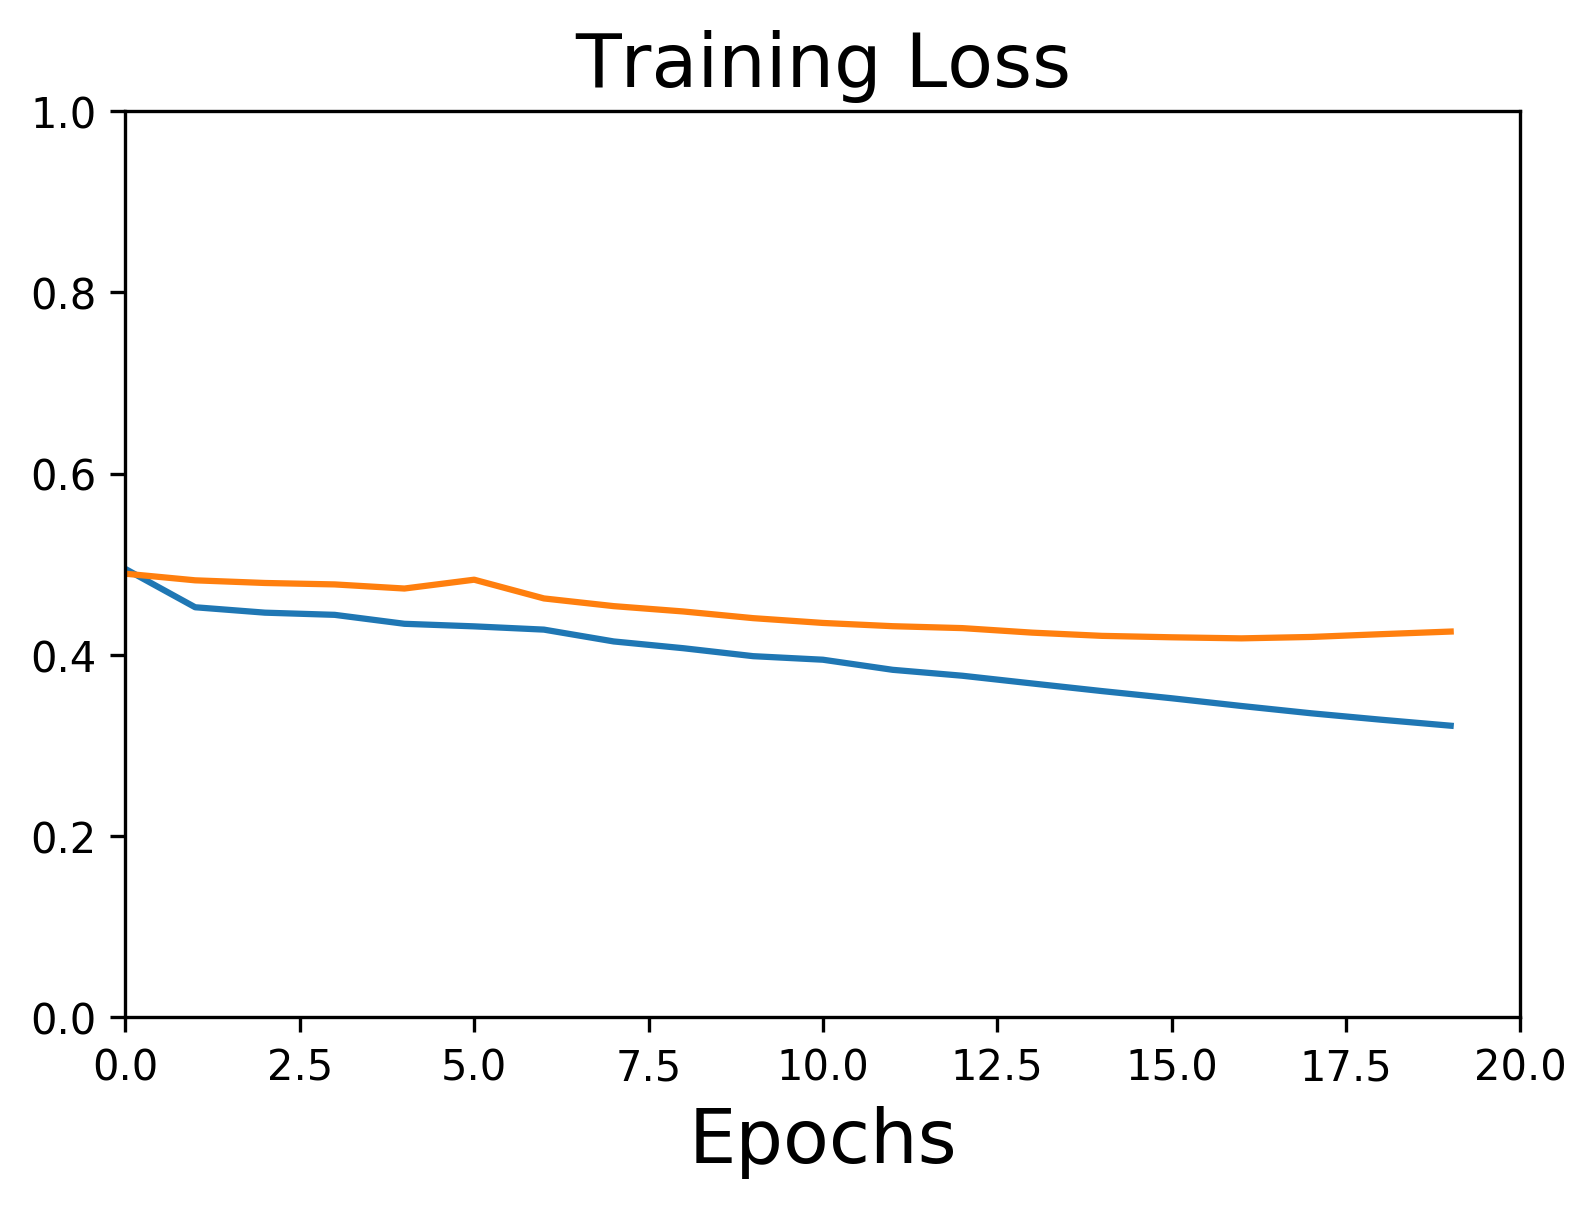

In [39]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, epochAvgLoss)
plt.plot(x, epochAvgLossValid)
plt.axis([0, epochPredictions.shape[0], 0, 1.0])
plt.title('Training Loss', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'loss.png'))

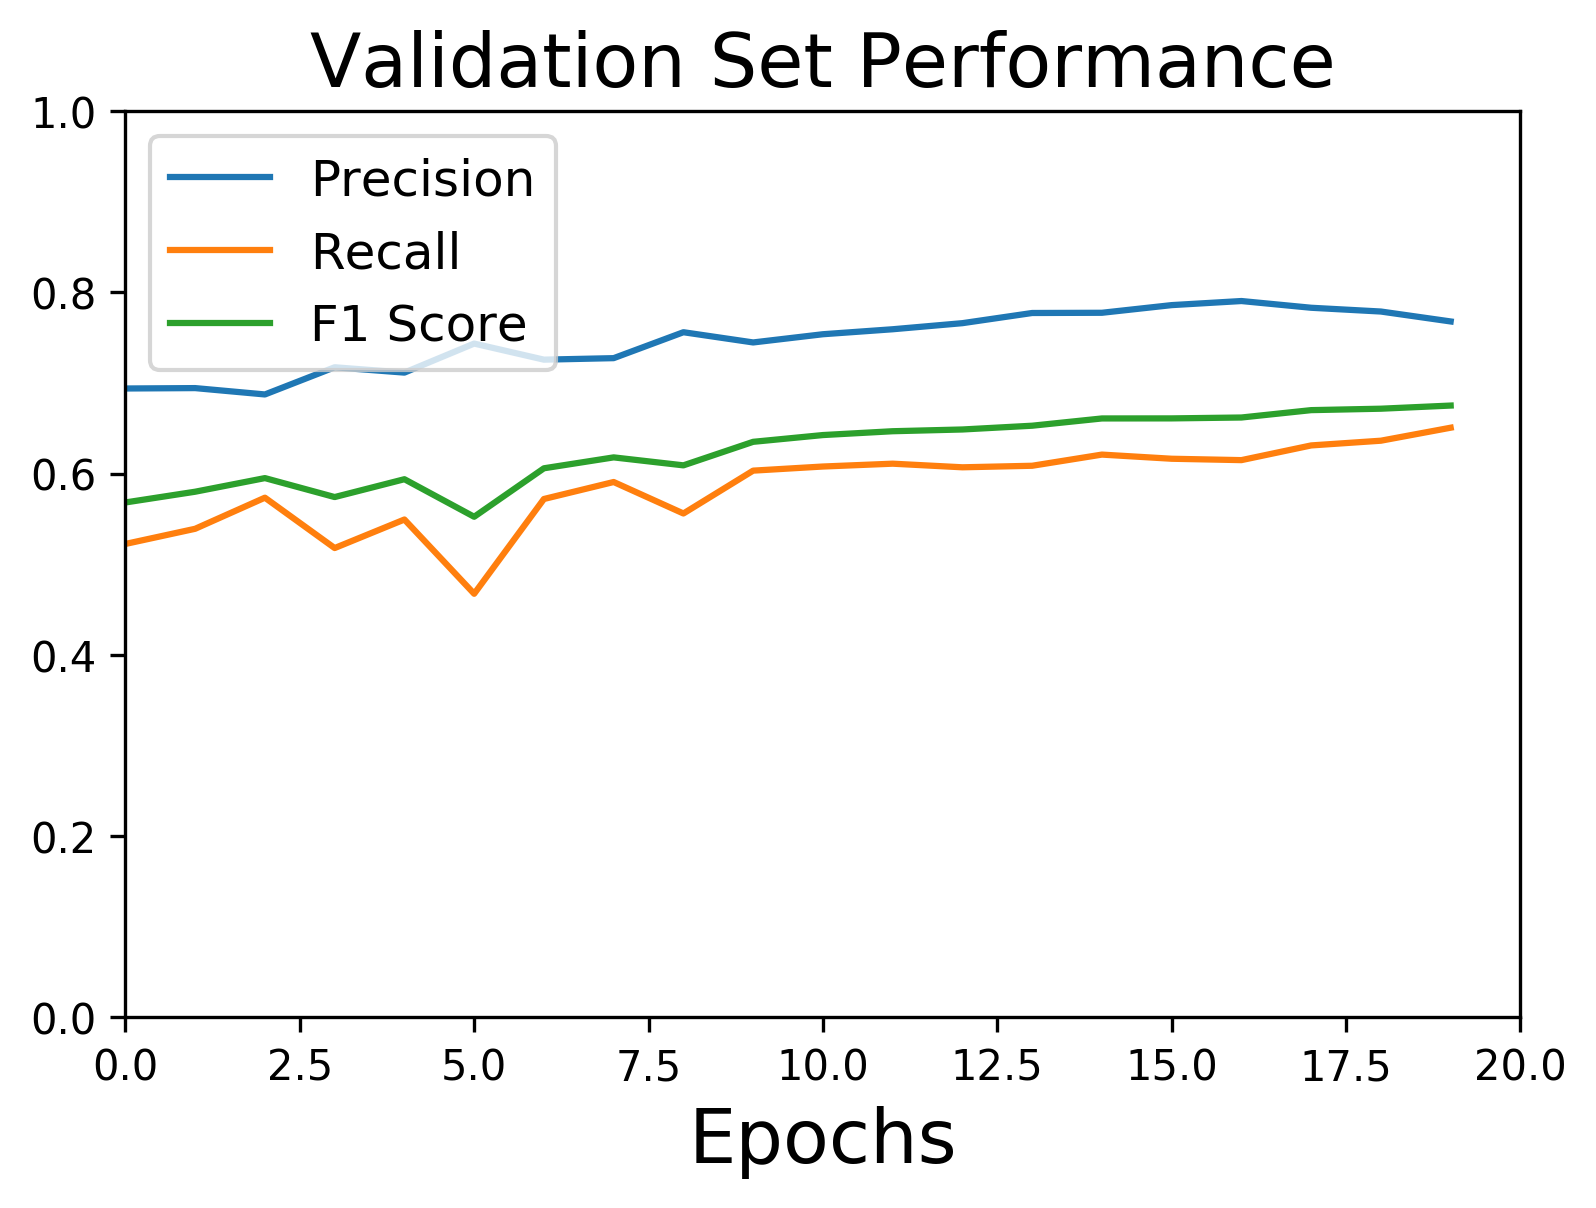

In [40]:
nEpochs = preds.shape[0]
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, precOverEpoch)
plt.plot(x, recOverEpoch)
plt.plot(x, f1OverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Precision', 'Recall', 'F1 Score'], loc='upper left', fontsize = 12)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'precRecF1.png'))
# fig.savefig('src/plotting/resultPlotting/performance.png')

In [41]:
f1OverEpoch

array([ 0.56810989,  0.57996744,  0.5949972 ,  0.57406934,  0.59376692,
        0.55230986,  0.6058232 ,  0.61786342,  0.60907202,  0.63503984,
        0.64250259,  0.64673414,  0.64865988,  0.65282398,  0.6608298 ,
        0.66090264,  0.66187229,  0.67001618,  0.6715896 ,  0.67506488])

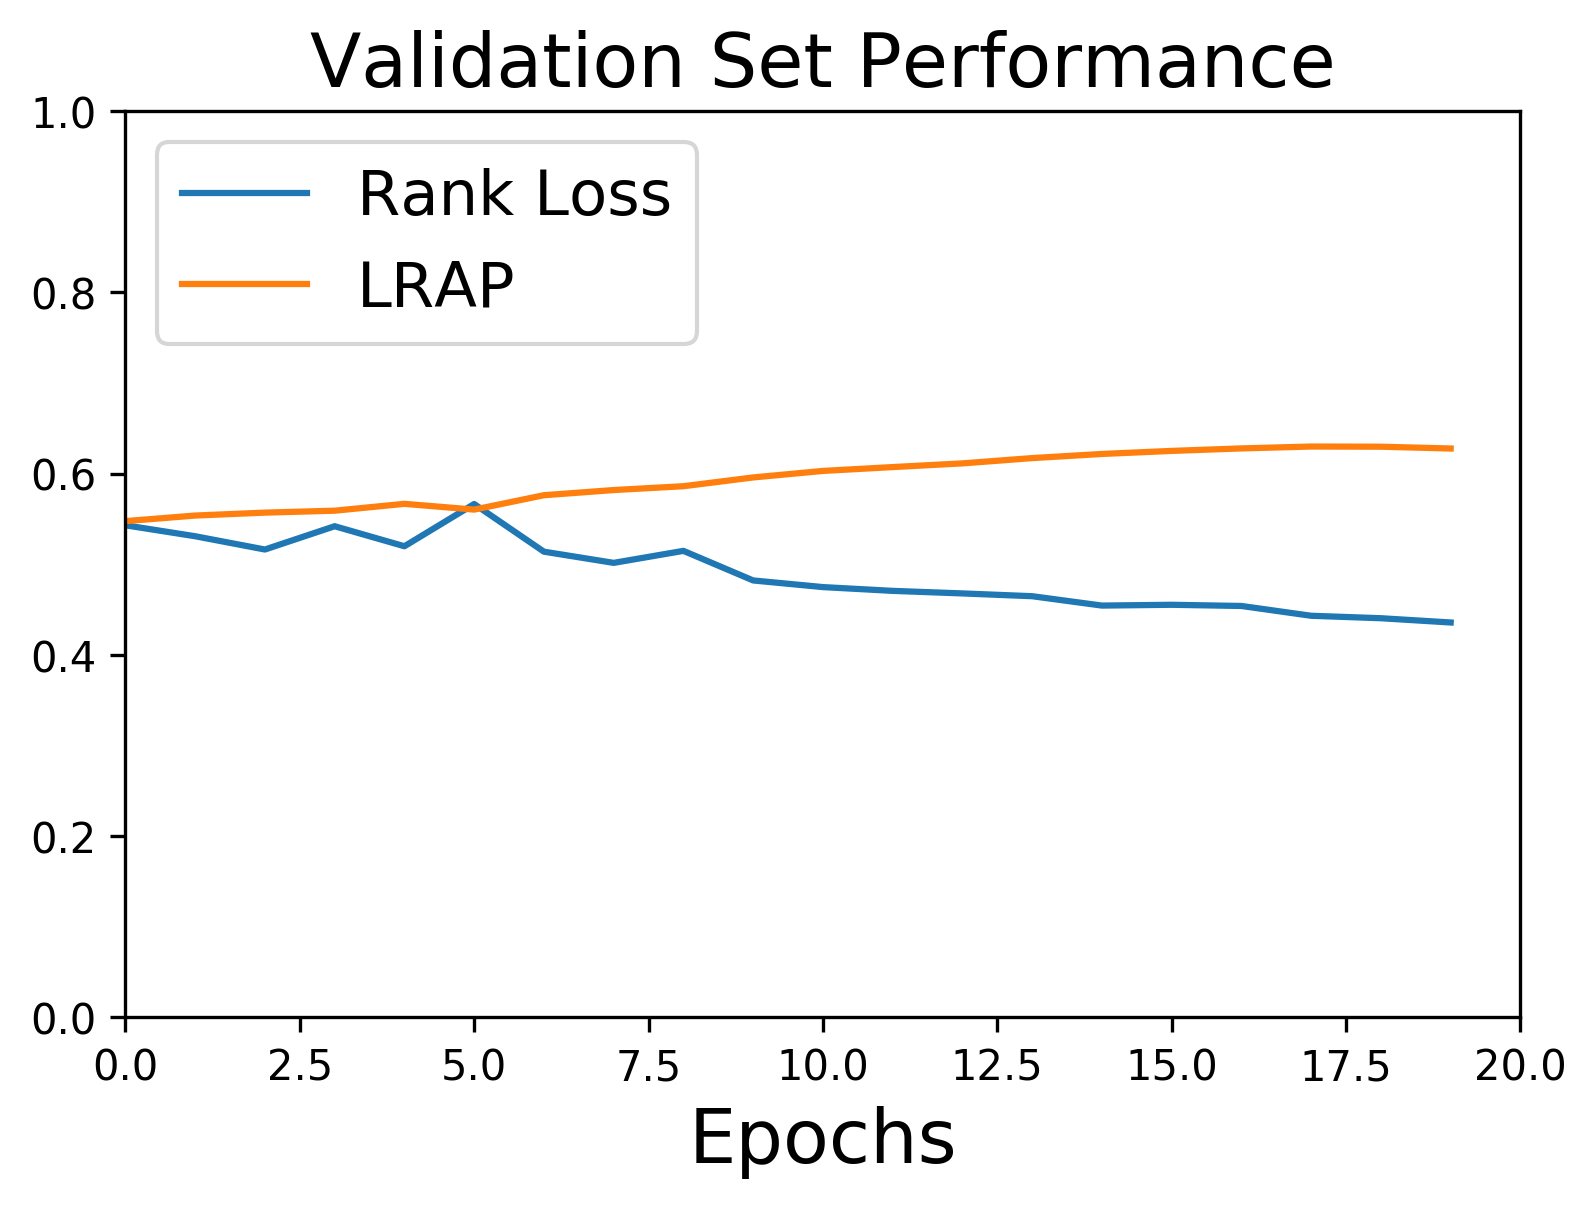

In [42]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, rankLossOverEpoch)
plt.plot(x, lrapOverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Rank Loss', 'LRAP'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'rankLoss.png'))

The mean number of codes in the devSet is 6.698


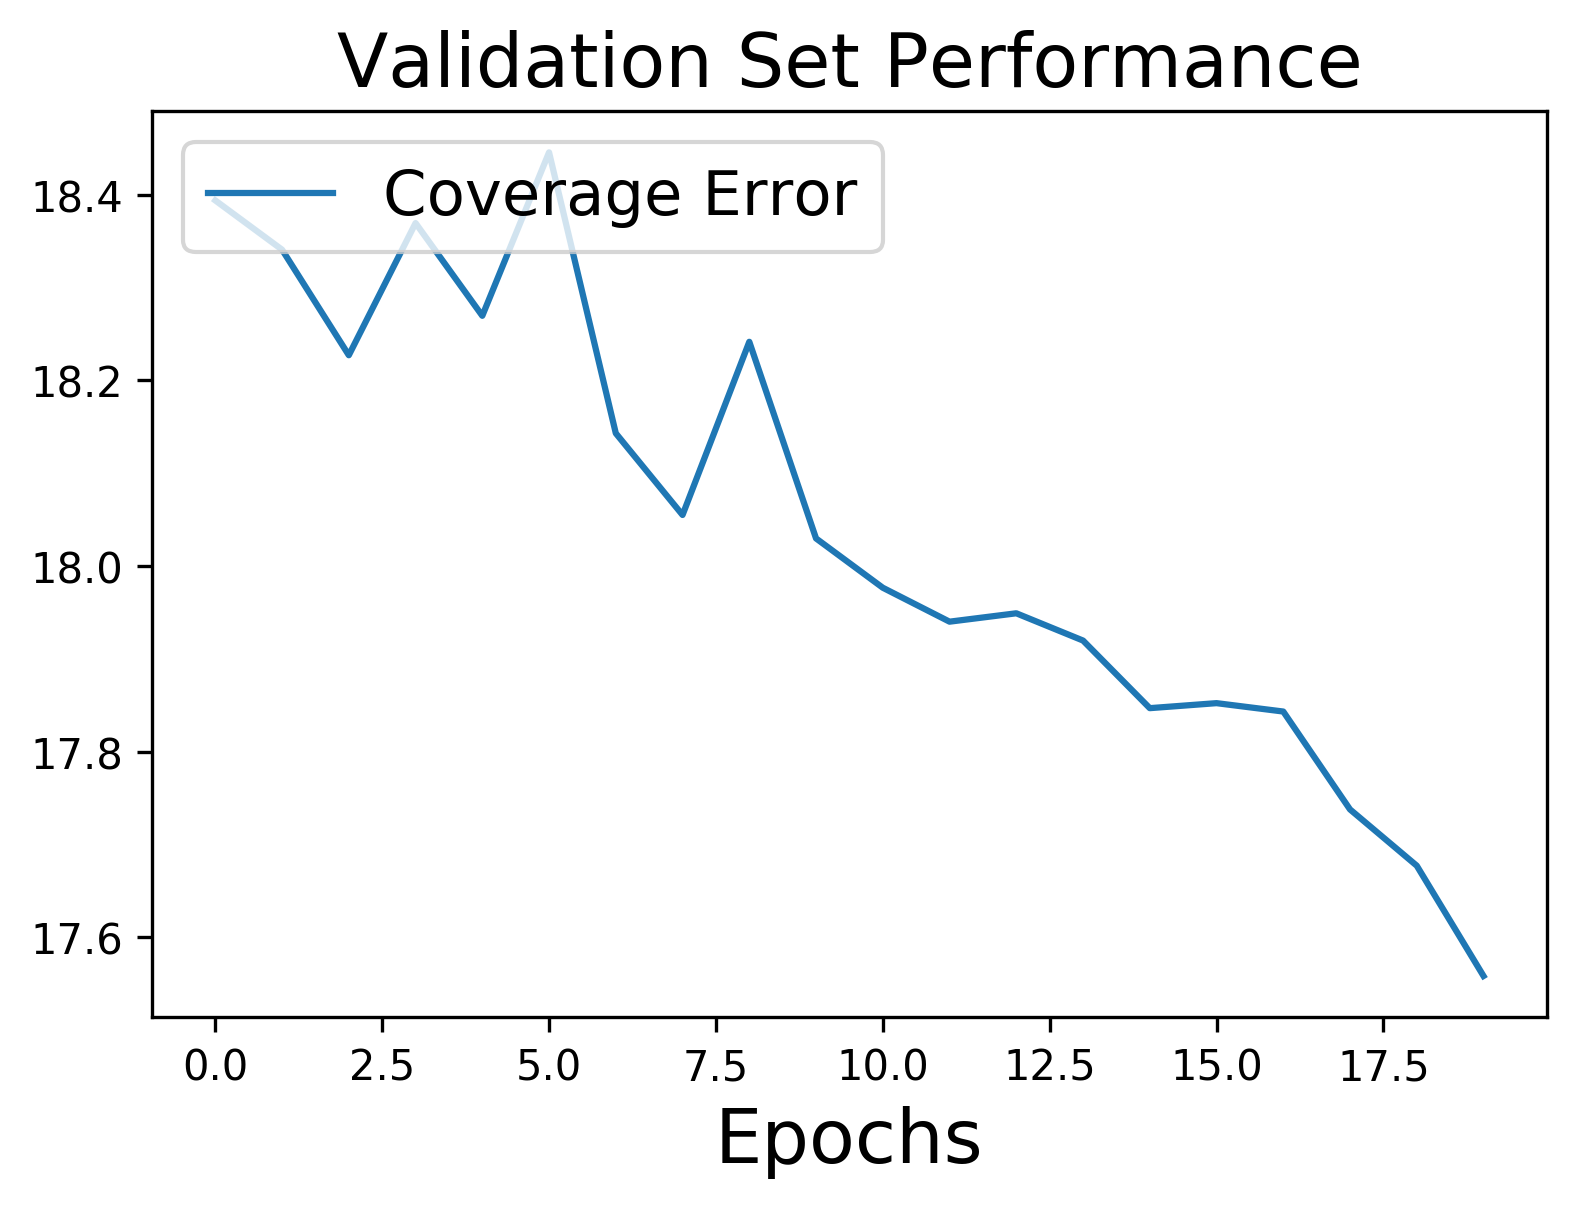

In [43]:
meanNumberOfCodes = np.sum(yDev, axis = 1)
meanNumberOfCodes = np.mean(meanNumberOfCodes)
print('The mean number of codes in the devSet is %.3f'%meanNumberOfCodes)
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, coverErrOverEpoch)

plt.legend(['Coverage Error'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'coverage.png'))

## Confusion Matrices
Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.


As of right now this code isn't real

In [44]:
with open(os.path.join(resultPath, 'features.pkl'), 'rb') as handle:
    icdDict = pickle.load(handle)[2]
#     icdDict = temp[2]
pp.pprint(icdDict)

{   'cat:1': 5,
    'cat:10': 10,
    'cat:11': 3,
    'cat:12': 17,
    'cat:13': 16,
    'cat:14': 13,
    'cat:15': 4,
    'cat:16': 9,
    'cat:17': 8,
    'cat:18': 18,
    'cat:19': 2,
    'cat:2': 15,
    'cat:3': 1,
    'cat:4': 12,
    'cat:5': 7,
    'cat:6': 11,
    'cat:7': 6,
    'cat:8': 0,
    'cat:9': 14}


In [45]:
predsBest = preds[bestEpoch,:,:]
yTruth = yDev
# confusionMatrix = np.zeros(shape = (temp.shape[1], temp.shape[1]))
# print(confusionMatrix)-
# currTruth = np.zeros(temp.shape[1])
# currPred = np.zeros(temp.shape[1])
for colIdx in range(yTruth.shape[1]):
    currTruth = yTruth[:, colIdx]
    currPred = predsBest[:, colIdx]
    confMat = metrics.confusion_matrix(y_true = currTruth, y_pred = currPred)
    print(confMat)
    prec = metrics.precision_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    rec = metrics.recall_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    f1 = metrics.f1_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    print('total positives {} or {} of the total'.format(np.sum(currPred), np.mean(currPred)))
    print('precision {}'.format(prec))
    print('recall {}'.format(rec))
    print('f1 score {}'.format(f1))
    print('***************************')
#     1/0

[[  854  1046]
 [  655 10626]]
total positives 11672.0 or 0.8855170320916471 of the total
precision 0.9103838245373543
recall 0.9419377714741601
f1 score 0.9258920402561757
***************************
[[1251 2092]
 [1020 8818]]
total positives 10910.0 or 0.827706547302936 of the total
precision 0.8082493125572869
recall 0.8963203903232364
f1 score 0.8500096394833238
***************************
[[1595 2232]
 [1337 8017]]
total positives 10249.0 or 0.777558607085957 of the total
precision 0.7822226558688653
recall 0.8570664956168484
f1 score 0.8179360301994593
***************************
[[5696 1164]
 [2339 3982]]
total positives 5146.0 or 0.39041043926864427 of the total
precision 0.7738048970073844
recall 0.6299636133523177
f1 score 0.6945146943402809
***************************
[[12695    15]
 [  461    10]]
total positives 25.0 or 0.0018966694484485243 of the total
precision 0.4
recall 0.021231422505307854
f1 score 0.04032258064516129
***************************
[[8282  761]
 [2046 2

/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


total positives 1549.0 or 0.11751763902587058 of the total
precision 0.8437701743060039
recall 0.5547538200339559
f1 score 0.6693982074263766
***************************
[[11334   164]
 [ 1541   142]]
total positives 306.0 or 0.02321523404900994 of the total
precision 0.46405228758169936
recall 0.0843731431966726
f1 score 0.14278531925590746
***************************
[[13158     0]
 [   23     0]]
total positives 0.0 or 0.0 of the total
precision 0.0
recall 0.0
f1 score 0.0
***************************
[[6058 1379]
 [2752 2992]]
total positives 4371.0 or 0.33161368636674 of the total
precision 0.6845115534202699
recall 0.520891364902507
f1 score 0.5915966386554622
***************************
